In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
mat = loadmat('ex3data1.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = mat['X']
y = mat['y']
y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

In [4]:
X.shape, y.shape

((5000, 400), (5000, 1))

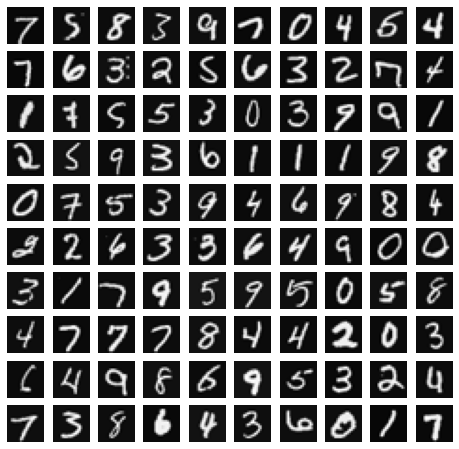

In [5]:
import matplotlib.image as img

fig, axis = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        axis[i, j].imshow(X[np.random.randint(0, 5001), :].reshape(20, 20, order='F'), cmap='gray')
        axis[i, j].axis('off')

# **VECTORIZING LOGISTIC REGRESSION**

**SIGMOID FUNCTION**

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

**COST FUNCTION**

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\Theta_j$ for $j\geq 1$


In [7]:
def lrCostFunction(theta, X, y, Lambda):
    m = len(y)
    
    h_theta = sigmoid(X@theta)
    
    y_pos = -y.T @ np.log(h_theta)
    y_neg = (1-y).T @ np.log(1-h_theta)
    err = y_pos - y_neg
    cost = 1/m * sum(err)
    regCost = cost + Lambda/(2*m) * sum(theta[1:] ** 2)
    
    j_0 = 1/m * (X.T @ (h_theta - y))[0]
    j_1 = 1/m * (X.T @ (h_theta - y))[1:] + (Lambda/m) * theta[1:]
    grad = np.vstack((j_0[:, np.newaxis], j_1))
    
    return regCost[0], grad

In [8]:
theta_t = np.array([-2, -1, 1, 2]).reshape(4, 1)
X_t = np.linspace(0.1, 1.5, 15).reshape(3, 5).T
X_t = np.column_stack((np.ones((5, 1)), X_t))
y_t = np.array([1, 0, 1, 0, 1]).reshape(5, 1)
cost, grad = lrCostFunction(theta_t, X_t, y_t, 3)

print("Cost:",cost,"Expected cost: 2.534819")
print("Gradients:\n",grad,"\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


**GRADIENT DESCENT**

In [9]:
def gradientDescent(theta, X, y, alpha, Lambda, n_iters):
    m = len(y)
    J_history = []
    for i in range(n_iters):
        cost, grad = lrCostFunction(theta, X, y, Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    return theta, J_history

**ONE VS ALL TRAINING**

In [10]:
def oneVsAll(X, y, num_labels, Lambda):
    m, n = X.shape
    X = np.column_stack((np.ones((m, 1)), X))
    initial_theta = np.zeros((n+1, 1))
    all_theta = []
    all_J=[]
    
    for i in range(1, num_labels+1):
        theta, J_history = gradientDescent(initial_theta, X, np.where(y==i, 1, 0), 1, Lambda, 300)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels, n+1), all_J

Text(0.5, 1.0, 'Cost function using Gradient Descent')

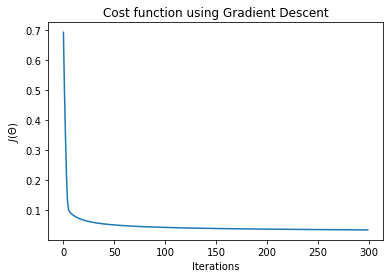

In [11]:
all_theta, all_J = oneVsAll(X, y, 10, 0.1)
plt.plot(all_J[:300])
plt.xlabel("Iterations")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

**ONE VS ALL PREDICTION**

In [12]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    X = np.column_stack((np.ones((m, 1)), X))
    predictions = sigmoid(X@all_theta.T)
    return np.argmax(predictions, axis=1)+1

In [13]:
pred = predictOneVsAll(all_theta, X)
print(f"Traning Accuracy: {np.mean(pred[:, np.newaxis]==y)*100}%")
# print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Traning Accuracy: 91.46%


# **NEURAL NETWORKS**

In [14]:
mat2 = loadmat('ex3weights.mat')
Theta1 = mat2['Theta1']
Theta2 = mat2['Theta2']

**FEEDFORWARD PROPAGATION**

In [15]:
def predict(Theta1, Theta2, X):
    a1 = np.column_stack((np.ones((X.shape[0], 1)), X))
    z2 = a1@Theta1.T
    a2 = sigmoid(z2)
    a2 = np.column_stack((np.ones((X.shape[0], 1)), a2))
    z3 = a2@Theta2.T
    a3 = sigmoid(z3)
    
    return np.argmax(a3, axis=1)+1

In [16]:
pred2 = predict(Theta1, Theta2, X)
print(f"Traning Accuracy: {np.mean(pred2[:, np.newaxis]==y)*100}%")

Traning Accuracy: 97.52%
